# Run all Tiny CNNs

This file runs all CNNs that are 2d, with and without context features

In [15]:
# 1. Load standard libraries FIRST
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import sys
import importlib
import inspect
import os
from torch.utils.data import DataLoader

# --- 1. Path Setup ---
# Try to locate the repository root by searching upward for a 'src' directory (or .git)
def find_repo_root(start_path=None, marker_dirs=('src', '.git')):
    p = os.path.abspath(start_path or os.getcwd())
    while True:
        if any(os.path.isdir(os.path.join(p, m)) for m in marker_dirs):
            return p
        parent = os.path.dirname(p)
        if parent == p:
            return None
        p = parent

repo_root = find_repo_root()
# Fallback to previous hardcoded path working on nuvolos
if repo_root is None:
    repo_root = "/files/pixlball"

if repo_root not in sys.path:
    sys.path.insert(0, repo_root)
print(f"Using repo_root: {repo_root}")

import src.data as data
import src.model as model
import src.train as train
import src.config as config
import src.dataset as dataset
import src.evaluate as evaluate
import src.utils as utils
import src.plotfunctions as plotfunctions
import src.losses as losses

from src.config import DEVICE 


# 4. Force a clean reload of your specific logic
importlib.reload(data)
importlib.reload(train)
importlib.reload(evaluate)
importlib.reload(model)
importlib.reload(dataset)
importlib.reload(utils)
importlib.reload(plotfunctions)
importlib.reload(losses)
importlib.reload(config)


utils.enforce_replicability(42)

Using repo_root: /files/pixlball


In [2]:
data_events = pd.read_parquet(os.path.join(repo_root, "data", "events_data.parquet"), engine="fastparquet")
data_360 = pd.read_parquet(os.path.join(repo_root, "data", "sb360_data.parquet"), engine="fastparquet")

In [3]:
df_with_targets = data.event_data_loader(data_events)
data_events = None
df_with_targets = data.add_ball_trajectory_features(df_with_targets)

133039 events.
counts of each outcome nn_target
Keep Possession    635414
Lose Possession    245066
Shot                38597
Name: count, dtype: int64


## Prepare 360 Data

In [4]:
df_360 = data.assign_grid_cells(data_360)
data_360 = None
nn_final = data.aggregate_nn_layers_vectorized(df_360)

## Finalize Df

In [5]:
nn_dataset = data.prepare_nn_dataset(df_with_targets, nn_final, target_cols=['nn_target', 'goal_flag'], context_cols = True, keep_context_ids = True ) # adjust cols depending on model
nn_dataset = data.add_context_cols(nn_dataset)
nn_dataset = data.add_target_as_int(nn_dataset)
nn_dataset, vector_names = data.add_ball_coordinates(nn_dataset)

## Weights

In [6]:
layer_columns = ["ball_layer", "teammates_layer", "opponents_layer"]
class_weights_event, goal_pos_weight = utils.get_multitask_loss_weights(nn_dataset, DEVICE)

print(f"Goal Positive Weight (0/1 ratio): {goal_pos_weight.item():.2f}")

Calculated Event Weights: [0.4530875322204915, 0.7430756467132296, 1.8038368210662787]
Goal Pos Weight: 5.0
Goal Positive Weight (0/1 ratio): 5.00


In [7]:
class_weights_event

tensor([0.4531, 0.7431, 1.8038])

# Prepare Datasets for CNNs

In [8]:
import numpy as np

layer_columns = ["ball_layer", "teammates_layer", "opponents_layer"]

# Use this to prepare your datasets for the final 10-epoch run
train_df, val_df = utils.perform_replicable_split(nn_dataset)

Replicable Split: 231 Train Matches, 58 Test Matches


## Run the Baseline Model

In [9]:

# Training Dataset extraction - Pass only the values in the correct order
train_dataset = dataset.PitchDatasetMultiTask(
    train_df[layer_columns],             # This maps to the 1st argument (features)
    train_df['nn_target_int'].values,    # This maps to the 2nd argument (events)
    train_df['goal_flag'].values         # This maps to the 3rd argument (goals)
)

# Validation Dataset extraction
validation_dataset = dataset.PitchDatasetMultiTask(
    val_df[layer_columns], 
    val_df['nn_target_int'].values, 
    val_df['goal_flag'].values
)

print(f"Total training samples: {len(train_dataset)}")
print(f"Total validation samples: {len(validation_dataset)}")
print(f"Goal Positive Weight (0/1 ratio): {goal_pos_weight.item():.2f}")


Total training samples: 643933
Total validation samples: 161667
Goal Positive Weight (0/1 ratio): 5.00


In [10]:
# 1. Initialize the architecture from the 'arch' module
# We name the variable 'baseline_model' to be even clearer
import src.model as arch
import src.losses as losses
from torch.utils.data import DataLoader, Dataset  # <--- Add this line

baseline_model = arch.TinyCNN_MultiTask_Threat(
    config.GRID_HEIGHT, 
    config.GRID_WIDTH, 
    config.NUM_EVENT_CLASSES
)

# 2. Setup criteria
criterion_ev = losses.FocalLossThreat(alpha=class_weights_event, gamma=2.0)
criterion_gl = nn.BCEWithLogitsLoss(pos_weight=torch.tensor([goal_pos_weight]).to(config.DEVICE))

# 3. Train using your unified function
train_loader = DataLoader(train_dataset, batch_size=config.BATCH_SIZE, shuffle=True)

# Note: train_multi_task_model should be in your main script or a 'utils' file
baseline_model = train.train_multi_task_model(
    baseline_model, 
    train_loader, 
    criterion_ev, 
    criterion_gl,
    config.BASELINE_NUM_EPOCHS,
    "Baseline"
)

Baseline Epoch 10: 100%|██████████| 20123/20123 [01:24<00:00, 237.61it/s, ev_loss=0.1313, loss=0.1479]


In [11]:
# Create a dictionary to hold the results for your table
final_results = {}

# 1. Baseline
final_results['Baseline'] = evaluate.evaluate_paper_metrics(baseline_model, validation_dataset, "Baseline 2D")


--- Baseline 2D Summary ---
Overall Acc: 0.5148 | Bal. Acc: 0.6055 | Goal AUC: 0.6092
Recall -> Keep: 0.4607 | Loss: 0.6254 | Shot: 0.7306


Matrix saved to figures/baseline_event_cm.png


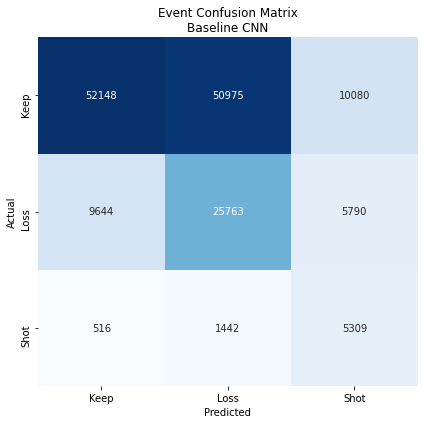

Matrix saved to figures/baseline_goal_cm.png


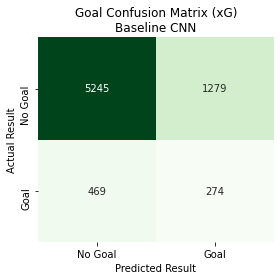

In [17]:
# 1. Get predictions for a specific model
res = evaluate.get_predictions(baseline_model, validation_dataset)

# 2. Extract Event Matrix
ev_cm = plotfunctions.plot_event_confusion_matrix(res['ev_targets'], res['ev_preds'], "Baseline CNN", "figures/baseline_event_cm.png")

# 3. Extract Goal Matrix
gl_cm = plotfunctions.plot_goal_confusion_matrix(res['gl_targets'], res['gl_preds'], "Baseline CNN", "figures/baseline_goal_cm.png")


## Run the Context Model

In [18]:
context_features = ['under_pressure', 'counterpress', 'dribble_nutmeg']

# Training Dataset extraction - Pass only the values in the correct order
train_dataset_context = dataset.ContextPitchDatasetMultiTask(
    train_df[layer_columns],             # This maps to the 1st argument (features)
    train_df['nn_target_int'].values,    # This maps to the 2nd argument (events)
    train_df['goal_flag'].values,
    train_df[context_features]        # This maps to the 3rd argument (goals)
)

# Validation Dataset extraction
validation_dataset_context = dataset.ContextPitchDatasetMultiTask(
    val_df[layer_columns], 
    val_df['nn_target_int'].values, 
    val_df['goal_flag'].values,
    val_df[context_features]  
)

print(f"Total training samples: {len(train_dataset_context)}")
print(f"Total validation samples: {len(validation_dataset_context)}")

Total training samples: 643933
Total validation samples: 161667


In [19]:
# --- 2. INITIALIZE CONTEXTUAL ARCHITECTURE ---
# Calculate how many features are in your context (e.g., 8 for ball vector)
num_ctx = len(context_features)

context_model = arch.TinyCNN_MultiTask_Context_Threat(
    grid_height=config.GRID_HEIGHT,
    grid_width=config.GRID_WIDTH,
    num_event_classes=config.NUM_EVENT_CLASSES,
    num_context_features=num_ctx
)

# --- 3. SETUP CRITERIA ---
# We reuse the same logic as the baseline
criterion_ev = losses.FocalLossThreat(alpha=class_weights_event, gamma=2.0)
criterion_gl = nn.BCEWithLogitsLoss(pos_weight=torch.tensor([goal_pos_weight]).to(config.DEVICE))

# --- 4. TRAIN USING UNIFIED FUNCTION ---
# The train_multi_task_model function you have is already 'unified' 
# It will detect the 4 items from the loader and pass context to the model automatically.
train_loader_ctx = DataLoader(train_dataset_context, batch_size=config.BATCH_SIZE, shuffle=True)

context_model = train.train_multi_task_model(
    context_model, 
    train_loader_ctx, 
    criterion_ev, 
    criterion_gl, 
    config.CONTEXT_NUM_EPOCHS,
    "Contextual-CNN"
)

Contextual-CNN Epoch 10: 100%|██████████| 20123/20123 [01:49<00:00, 182.97it/s, ev_loss=0.1061, loss=0.2116] 


In [20]:

# 2. Situational Context
final_results['Context-Situational'] = evaluate.evaluate_paper_metrics(context_model, validation_dataset_context, "Situational")



--- Situational Summary ---
Overall Acc: 0.5240 | Bal. Acc: 0.6151 | Goal AUC: 0.6101
Recall -> Keep: 0.4780 | Loss: 0.6091 | Shot: 0.7581


Matrix saved to figures/context_event_cm.png


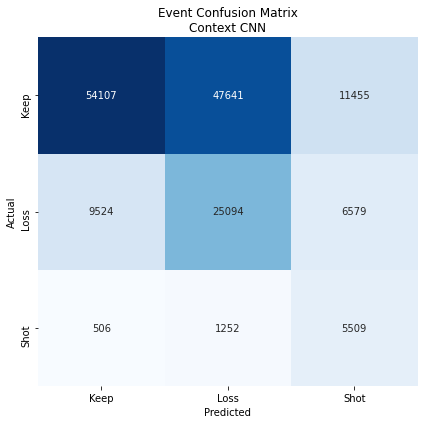

Matrix saved to figures/context_goal_cm.png


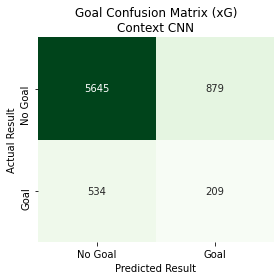

In [21]:
# 1. Get predictions for a specific model
res = evaluate.get_predictions(context_model, validation_dataset_context)

# 2. Extract Event Matrix
ev_cm = plotfunctions.plot_event_confusion_matrix(res['ev_targets'], res['ev_preds'], "Context CNN", "figures/context_event_cm.png")

# 3. Extract Goal Matrix
gl_cm = plotfunctions.plot_goal_confusion_matrix(res['gl_targets'], res['gl_preds'], "Context CNN", "figures/context_goal_cm.png")


## Run the Ball Vector Context Model

In [22]:
# -------------------------------------------------------------
# 3. Extract the arrays and Instantiate the Datasets (FIXED)
# -------------------------------------------------------------

# Training Dataset extraction - Pass only the values in the correct order
## NAME KINETIC DATASET / KINETIC MODEL
train_dataset_kinetic = dataset.ContextBallVectorPitchDatasetMultiTask(
    train_df[layer_columns],             # This maps to the 1st argument (features)
    train_df['nn_target_int'].values,    # This maps to the 2nd argument (events)
    train_df['goal_flag'].values,
    train_df[vector_names]        # This maps to the 3rd argument (goals)
)

# Validation Dataset extraction
validation_dataset_kinetic = dataset.ContextBallVectorPitchDatasetMultiTask(
    val_df[layer_columns], 
    val_df['nn_target_int'].values, 
    val_df['goal_flag'].values,
    val_df[vector_names]  
)

print(f"Total training samples: {len(train_dataset_kinetic)}")
print(f"Total validation samples: {len(validation_dataset_kinetic)}")

Total training samples: 643933
Total validation samples: 161667


In [23]:
import src.model as arch
import src.losses as losses
from torch.utils.data import DataLoader

# --- 1. INITIALIZE KINETIC ARCHITECTURE ---
# Identify number of features in your ball vector (e.g., 8)
# Ensure 'train_kinetic_dataset' is the one containing your normalized ball vectors
num_kinetic_features = 8

kinetic_model = arch.TinyCNN_MultiTask_Context_Threat(
    grid_height=config.GRID_HEIGHT,
    grid_width=config.GRID_WIDTH,
    num_event_classes=config.NUM_EVENT_CLASSES,
    num_context_features=num_kinetic_features
)

# --- 2. SETUP CRITERIA ---
# Reusing your standard weights and config for consistency across all 4 models
criterion_ev = losses.FocalLossThreat(alpha=class_weights_event, gamma=2.0)
criterion_gl = nn.BCEWithLogitsLoss(pos_weight=torch.tensor([goal_pos_weight]).to(config.DEVICE))

# --- 3. TRAIN ---
# The train_loader must be built from your kinetic dataset
train_loader_kin = DataLoader(train_dataset_kinetic, batch_size=config.BATCH_SIZE, shuffle=True)

# Unified training function handles the 4-item unpack automatically
kinetic_model = train.train_multi_task_model(
    kinetic_model, 
    train_loader_kin, 
    criterion_ev, 
    criterion_gl,
    config.KINETIC_NUM_EPOCHS,
    "Kinetic-Vector-CNN"
)

Kinetic-Vector-CNN Epoch 10: 100%|██████████| 20123/20123 [01:54<00:00, 176.22it/s, ev_loss=0.3001, loss=0.4074]


In [24]:
# 3. Kinetic Context (Ball Vector)
final_results['Context-Kinetic'] = evaluate.evaluate_paper_metrics(kinetic_model, validation_dataset_kinetic, "Kinetic")



--- Kinetic Summary ---
Overall Acc: 0.5412 | Bal. Acc: 0.6219 | Goal AUC: 0.6106
Recall -> Keep: 0.5068 | Loss: 0.5971 | Shot: 0.7618


Matrix saved to figures/kinetic_event_cm.png


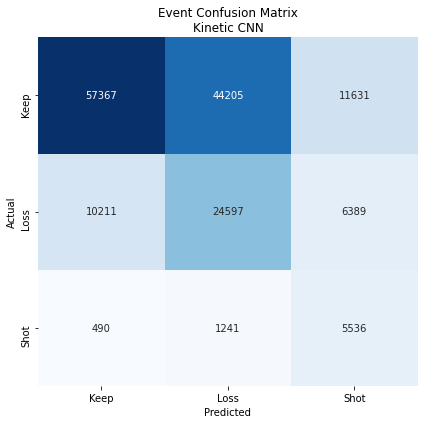

Matrix saved to figures/kinetic_goal_cm.png


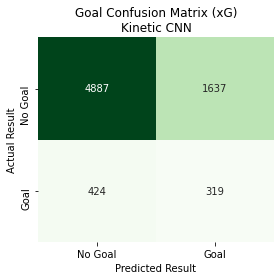

In [37]:
# 1. Get predictions for a specific model (e.g., Kinetic)
res = evaluate.get_predictions(kinetic_model, validation_dataset_kinetic)

# 2. Extract Event Matrix
ev_cm = plotfunctions.plot_event_confusion_matrix(res['ev_targets'], res['ev_preds'], "Kinetic CNN", "figures/kinetic_event_cm.png")

# 3. Extract Goal Matrix
gl_cm = plotfunctions.plot_goal_confusion_matrix(res['gl_targets'], res['gl_preds'], "Kinetic CNN", "figures/kinetic_goal_cm.png")


# Run 3D CNN

In [ ]:
# 1. Generate the 4D Voxels (Channels, Time, Height, Width)
# Lookback 3 = 4 frames total (t, t-1, t-2, t-3)
voxels_list = data.generate_temporal_voxels(nn_dataset, lookback=3)

# 2. Add as a column
nn_dataset['temporal_voxel'] = voxels_list

train_df, test_df = utils.perform_replicable_split(nn_dataset)


In [27]:
train_dataset_3d = dataset.VoxelPitchDataset(train_df)
test_dataset_3d = dataset.VoxelPitchDataset(test_df)

# SMOKE TEST: Check the shape of the first item
voxel, event, goal = train_dataset_3d[0]
print(f"Voxel Shape: {voxel.shape}") # MUST be [3, 4, 12, 8]

Voxel Shape: torch.Size([3, 4, 12, 8])


In [28]:
event_weights = [0.7, 1.3, 2.0]
class_weights_event = torch.tensor(event_weights, dtype=torch.float32).to(config.DEVICE)

In [ ]:
importlib.reload(config)
import src.model as arch # issues with imports -> workarround
importlib.reload(arch)

# --- 1. INITIALIZE 3D ARCHITECTURE ---
# This model expects a voxel volume (e.g., 4 frames of spatial grids)
voxel_model = arch.Tiny3DCNN_MultiTask(
    num_event_classes=config.NUM_EVENT_CLASSES
)

# --- 2. SETUP CRITERIA ---
# Standardize the loss to ensure a fair comparison with the 2D models
criterion_ev = losses.FocalLossThreat(alpha=class_weights_event, gamma=2.0)
criterion_gl = nn.BCEWithLogitsLoss(pos_weight=torch.tensor([goal_pos_weight]).to(config.DEVICE))

# --- 3. TRAIN ---
# The train_loader must be built from your 3D Voxel dataset
# Ensure your 3D dataset returns (voxels, event_targets, goal_targets)
train_loader_3d = DataLoader(train_dataset_3d, batch_size=config.BATCH_SIZE, shuffle=True)

# The unified training function will see 3 items (Voxels, Event, Goal)
# and treat 'Voxels' as the single 'inputs' argument.
voxel_model = train.train_multi_task_model(
    voxel_model, 
    train_loader_3d, 
    criterion_ev, 
    criterion_gl, 
    5,
    "3D-Voxel-CNN",
    lr = config.LR_3D
)

3D-Voxel-CNN Epoch 5:  71%|███████   | 14214/20123 [01:47<00:50, 116.52it/s, ev_loss=0.2781, loss=0.4169]

# Evaluation

In [ ]:
# 4. 3D CNN
final_results['3D-Voxel'] = evaluate.evaluate_paper_metrics(voxel_model, test_dataset_3d, "3D CNN")

Matrix saved to figures/voxel_event_cm.png


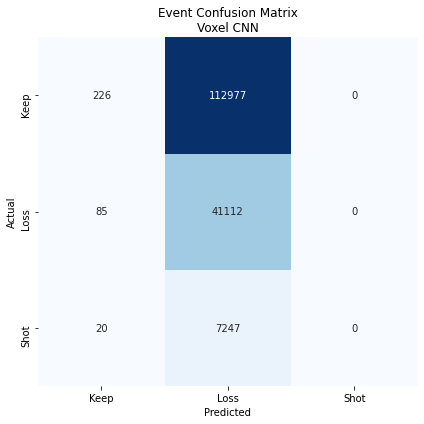

Matrix saved to figures/voxel_goal_cm.png


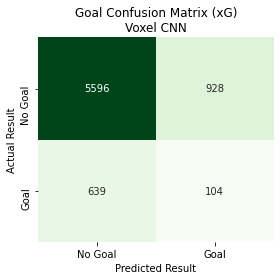

In [36]:
# 1. Get predictions for a specific model (e.g., Kinetic)
res = evaluate.get_predictions(voxel_model, test_dataset_3d)

# 2. Extract Event Matrix
ev_cm = plotfunctions.plot_event_confusion_matrix(res['ev_targets'], res['ev_preds'], "Voxel CNN", "figures/voxel_event_cm.png")

# 3. Extract Goal Matrix
gl_cm = plotfunctions.plot_goal_confusion_matrix(res['gl_targets'], res['gl_preds'], "Voxel CNN", "figures/voxel_goal_cm.png")


# Combined Results

In [35]:
# Assuming you've run the function for all 4 models as final_results['ModelName']
# Example: final_results['Baseline'] = evaluate_paper_metrics(baseline_model, val_dataset, "Baseline")

# Convert results dictionary to a clean DataFrame
df_results = pd.DataFrame(final_results).T

# Reorder columns for the paper
columns_order = ["Accuracy", "Balanced Acc", "Recall_Keep", "Recall_Loss", "Recall_Shot", "Goal AUC"]
df_results = df_results[columns_order]

print("\nFINAL UTILITY COMPARISON TABLE")
print(df_results)



FINAL UTILITY COMPARISON TABLE
                     Accuracy  Balanced Acc  Recall_Keep  Recall_Loss  \
Baseline             0.514762      0.605528     0.460659     0.625361   
Context-Situational  0.523978      0.615057     0.477964     0.609122   
Context-Kinetic      0.541236      0.621873     0.506762     0.597058   
3D-Voxel             0.255698      0.333311     0.001996     0.997937   

                     Recall_Shot  Goal AUC  
Baseline                0.730563  0.609219  
Context-Situational     0.758084  0.610093  
Context-Kinetic         0.761800  0.610564  
3D-Voxel                0.000000  0.483201  


In [ ]:
df_results.to_csv("model_comparison_table.csv", index=False)

In [34]:
1+1

2